# Task 1: Introduction

---

For this project, we are going to work on evaluating price of houses given the following features:

1. Year of sale of the house
2. The age of the house at the time of sale
3. Distance from city center
4. Number of stores in the locality
5. The latitude
6. The longitude

![Regression](images/regression.png)

Note: This notebook uses `python 3` and these packages: `tensorflow`, `pandas`, `matplotlib`, `scikit-learn`.

## 1.1: Importing Libraries & Helper Functions

First of all, we will need to import some libraries and helper functions. This includes TensorFlow and some utility functions that I've written to save time.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print('Libraries imported.')

Libraries imported.


# Task 2: Importing the Data

## 2.1: Importing the Data

The dataset is saved in a `data.csv` file. We will use `pandas` to take a look at some of the rows.

In [4]:
df = pd.read_csv('data.csv', names = column_names) 
df.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


## 2.2: Check Missing Data

It's a good practice to check if the data has any missing values. In real world data, this is quite common and must be taken care of before any data pre-processing or model training.

In [5]:
df.isna().sum()

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

# Task 3: Data Normalization

## 3.1: Data Normalization

We can make it easier for optimization algorithms to find minimas by normalizing the data before training a model.

In [6]:
df = df.iloc[:,1:]
df_norm = (df - df.mean()) / df.std()
df_norm.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


## 3.2: Convert Label Value

Because we are using normalized values for the labels, we will get the predictions back from a trained model in the same distribution. So, we need to convert the predicted values back to the original distribution if we want predicted prices.

In [7]:
y_mean = df['price'].mean()
y_std = df['price'].std()

def convert_label_value(pred):
    return int(pred * y_std + y_mean)

print(convert_label_value(0.350088))

14263


# Task 4: Create Training and Test Sets

## 4.1: Select Features

Make sure to remove the column __price__ from the list of features as it is the label and should not be used as a feature.

In [8]:
X = df_norm.iloc[:, :6]
X.head()

,date,age,distance,stores,latitude,longitude
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


## 4.2: Select Labels

In [9]:
Y = df_norm.iloc[:, -1]
Y.head()

0    0.350088
1   -1.836486
2   -0.339584
3   -1.839425
4    0.245266
Name: price, dtype: float64

## 4.3: Feature and Label Values

We will need to extract just the numeric values for the features and labels as the TensorFlow model will expect just numeric values as input.

In [10]:
X_arr = X.values
Y_arr = Y.values

print('X_arr shape: ', X_arr.shape)
print('Y_arr shape: ', Y_arr.shape)

X_arr shape:  (5000, 6)
Y_arr shape:  (5000,)


## 4.4: Train and Test Split

We will keep some part of the data aside as a __test__ set. The model will not use this set during training and it will be used only for checking the performance of the model in trained and un-trained states. This way, we can make sure that we are going in the right direction with our model training.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_arr, Y_arr, test_size = 0.05, shuffle = True, random_state=0)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (4750, 6)
y_train shape:  (4750,)
X_test shape:  (250, 6)
y_test shape:  (250,)


# Task 5: Create the Model

## 5.1: Create the Model

Let's write a function that returns an untrained model of a certain architecture.

In [13]:
def get_model():
    
    model = Sequential([
        Dense(10, input_shape = (6,), activation = 'relu'),
        Dense(20, activation = 'relu'),
        Dense(5, activation = 'relu'),
        Dense(1)
    ])

    model.compile(
        loss='mse',
        optimizer='adadelta'
    )
    
    return model

model = get_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                70        
_________________________________________________________________
dense_5 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 6         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


# Task 6: Model Training

## 6.1: Model Training

We can use an `EarlyStopping` callback from Keras to stop the model training if the validation loss stops decreasing for a few epochs.

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5)

model = get_model()

preds_on_untrained = model.predict(X_test)

history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 1000,
    callbacks = [early_stopping]
)

Epoch 1/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.2446 - val_loss: 1.0504
Epoch 2/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.2426 - val_loss: 1.0488
Epoch 3/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.2407 - val_loss: 1.0472
Epoch 4/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.2387 - val_loss: 1.0456
Epoch 5/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.2367 - val_loss: 1.0439
Epoch 6/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.2347 - val_loss: 1.0423
Epoch 7/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.2327 - val_loss: 1.0406
Epoch 8/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.2307 - val_loss: 1.0390
Epoch 9/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.2287 - val_loss: 1.0374
Epoch 10/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.226

149/149 [==============================] - 0s 2ms/step - loss: 1.1101 - val_loss: 0.9415
Epoch 81/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.1087 - val_loss: 0.9403
Epoch 82/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.1073 - val_loss: 0.9392
Epoch 83/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.1059 - val_loss: 0.9381
Epoch 84/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.1045 - val_loss: 0.9370
Epoch 85/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.1032 - val_loss: 0.9359
Epoch 86/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.1018 - val_loss: 0.9348
Epoch 87/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.1005 - val_loss: 0.9337
Epoch 88/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0991 - val_loss: 0.9326
Epoch 89/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0978 - v

Epoch 159/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0177 - val_loss: 0.8680
Epoch 160/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0168 - val_loss: 0.8672
Epoch 161/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0158 - val_loss: 0.8664
Epoch 162/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0148 - val_loss: 0.8656
Epoch 163/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0138 - val_loss: 0.8649
Epoch 164/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0129 - val_loss: 0.8641
Epoch 165/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0119 - val_loss: 0.8633
Epoch 166/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0109 - val_loss: 0.8625
Epoch 167/1000
149/149 [==============================] - 0s 1ms/step - loss: 1.0100 - val_loss: 0.8618
Epoch 168/1000
149/149 [==============================] - 0s 1ms

Epoch 238/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9467 - val_loss: 0.8110
Epoch 239/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9458 - val_loss: 0.8103
Epoch 240/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9450 - val_loss: 0.8096
Epoch 241/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9441 - val_loss: 0.8089
Epoch 242/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9433 - val_loss: 0.8082
Epoch 243/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9424 - val_loss: 0.8075
Epoch 244/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9416 - val_loss: 0.8068
Epoch 245/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9407 - val_loss: 0.8062
Epoch 246/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.9399 - val_loss: 0.8055
Epoch 247/1000
149/149 [==============================] - 0s 1ms

149/149 [==============================] - 0s 1ms/step - loss: 0.8800 - val_loss: 0.7565
Epoch 317/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8791 - val_loss: 0.7558
Epoch 318/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8782 - val_loss: 0.7551
Epoch 319/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8774 - val_loss: 0.7544
Epoch 320/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8765 - val_loss: 0.7536
Epoch 321/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8756 - val_loss: 0.7529
Epoch 322/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8747 - val_loss: 0.7522
Epoch 323/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8738 - val_loss: 0.7515
Epoch 324/1000
149/149 [==============================] - 0s 987us/step - loss: 0.8730 - val_loss: 0.7507
Epoch 325/1000
149/149 [==============================] - 0s 1ms/step - loss:

149/149 [==============================] - 0s 1ms/step - loss: 0.8091 - val_loss: 0.6968
Epoch 395/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8081 - val_loss: 0.6960
Epoch 396/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8072 - val_loss: 0.6952
Epoch 397/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8063 - val_loss: 0.6944
Epoch 398/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8053 - val_loss: 0.6936
Epoch 399/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8044 - val_loss: 0.6928
Epoch 400/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8034 - val_loss: 0.6920
Epoch 401/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8025 - val_loss: 0.6911
Epoch 402/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8015 - val_loss: 0.6903
Epoch 403/1000
149/149 [==============================] - 0s 972us/step - loss:

Epoch 472/1000
149/149 [==============================] - 0s 975us/step - loss: 0.7305 - val_loss: 0.6279
Epoch 473/1000
149/149 [==============================] - 0s 950us/step - loss: 0.7294 - val_loss: 0.6269
Epoch 474/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7284 - val_loss: 0.6260
Epoch 475/1000
149/149 [==============================] - 0s 934us/step - loss: 0.7273 - val_loss: 0.6250
Epoch 476/1000
149/149 [==============================] - 0s 927us/step - loss: 0.7262 - val_loss: 0.6240
Epoch 477/1000
149/149 [==============================] - 0s 948us/step - loss: 0.7251 - val_loss: 0.6230
Epoch 478/1000
149/149 [==============================] - 0s 939us/step - loss: 0.7240 - val_loss: 0.6219
Epoch 479/1000
149/149 [==============================] - 0s 961us/step - loss: 0.7229 - val_loss: 0.6209
Epoch 480/1000
149/149 [==============================] - 0s 927us/step - loss: 0.7218 - val_loss: 0.6199
Epoch 481/1000
149/149 [========================

149/149 [==============================] - 0s 931us/step - loss: 0.6425 - val_loss: 0.5478
Epoch 550/1000
149/149 [==============================] - 0s 931us/step - loss: 0.6413 - val_loss: 0.5467
Epoch 551/1000
149/149 [==============================] - 0s 934us/step - loss: 0.6401 - val_loss: 0.5456
Epoch 552/1000
149/149 [==============================] - 0s 937us/step - loss: 0.6389 - val_loss: 0.5444
Epoch 553/1000
149/149 [==============================] - 0s 951us/step - loss: 0.6377 - val_loss: 0.5433
Epoch 554/1000
149/149 [==============================] - 0s 938us/step - loss: 0.6364 - val_loss: 0.5422
Epoch 555/1000
149/149 [==============================] - 0s 972us/step - loss: 0.6352 - val_loss: 0.5411
Epoch 556/1000
149/149 [==============================] - 0s 937us/step - loss: 0.6340 - val_loss: 0.5400
Epoch 557/1000
149/149 [==============================] - 0s 938us/step - loss: 0.6328 - val_loss: 0.5388
Epoch 558/1000
149/149 [==============================] - 0s 

149/149 [==============================] - 0s 1ms/step - loss: 0.5461 - val_loss: 0.4587
Epoch 628/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5449 - val_loss: 0.4576
Epoch 629/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5436 - val_loss: 0.4564
Epoch 630/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5423 - val_loss: 0.4552
Epoch 631/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5411 - val_loss: 0.4541
Epoch 632/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5398 - val_loss: 0.4529
Epoch 633/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.5385 - val_loss: 0.4518
Epoch 634/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.5373 - val_loss: 0.4506
Epoch 635/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.5360 - val_loss: 0.4494
Epoch 636/1000
149/149 [==============================] - 0s 1ms/step - loss: 0

149/149 [==============================] - 0s 956us/step - loss: 0.4493 - val_loss: 0.3717
Epoch 706/1000
149/149 [==============================] - 0s 969us/step - loss: 0.4481 - val_loss: 0.3707
Epoch 707/1000
149/149 [==============================] - 0s 928us/step - loss: 0.4470 - val_loss: 0.3696
Epoch 708/1000
149/149 [==============================] - 0s 941us/step - loss: 0.4458 - val_loss: 0.3686
Epoch 709/1000
149/149 [==============================] - 0s 960us/step - loss: 0.4446 - val_loss: 0.3675
Epoch 710/1000
149/149 [==============================] - 0s 941us/step - loss: 0.4434 - val_loss: 0.3665
Epoch 711/1000
149/149 [==============================] - 0s 943us/step - loss: 0.4422 - val_loss: 0.3655
Epoch 712/1000
149/149 [==============================] - 0s 927us/step - loss: 0.4410 - val_loss: 0.3644
Epoch 713/1000
149/149 [==============================] - 0s 935us/step - loss: 0.4399 - val_loss: 0.3634
Epoch 714/1000
149/149 [==============================] - 0s 

149/149 [==============================] - 0s 1ms/step - loss: 0.3651 - val_loss: 0.2984
Epoch 783/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3641 - val_loss: 0.2975
Epoch 784/1000
149/149 [==============================] - 0s 952us/step - loss: 0.3631 - val_loss: 0.2967
Epoch 785/1000
149/149 [==============================] - 0s 921us/step - loss: 0.3621 - val_loss: 0.2959
Epoch 786/1000
149/149 [==============================] - 0s 975us/step - loss: 0.3612 - val_loss: 0.2950
Epoch 787/1000
149/149 [==============================] - 0s 943us/step - loss: 0.3602 - val_loss: 0.2942
Epoch 788/1000
149/149 [==============================] - 0s 969us/step - loss: 0.3592 - val_loss: 0.2934
Epoch 789/1000
149/149 [==============================] - 0s 948us/step - loss: 0.3583 - val_loss: 0.2926
Epoch 790/1000
149/149 [==============================] - 0s 936us/step - loss: 0.3573 - val_loss: 0.2918
Epoch 791/1000
149/149 [==============================] - 0s 936u

149/149 [==============================] - 0s 948us/step - loss: 0.3007 - val_loss: 0.2443
Epoch 860/1000
149/149 [==============================] - 0s 932us/step - loss: 0.3000 - val_loss: 0.2438
Epoch 861/1000
149/149 [==============================] - 0s 937us/step - loss: 0.2993 - val_loss: 0.2433
Epoch 862/1000
149/149 [==============================] - 0s 980us/step - loss: 0.2986 - val_loss: 0.2427
Epoch 863/1000
149/149 [==============================] - 0s 940us/step - loss: 0.2979 - val_loss: 0.2422
Epoch 864/1000
149/149 [==============================] - 0s 934us/step - loss: 0.2973 - val_loss: 0.2416
Epoch 865/1000
149/149 [==============================] - 0s 945us/step - loss: 0.2966 - val_loss: 0.2411
Epoch 866/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2959 - val_loss: 0.2406
Epoch 867/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2953 - val_loss: 0.2400
Epoch 868/1000
149/149 [==============================] - 0s 947u

149/149 [==============================] - 0s 1ms/step - loss: 0.2576 - val_loss: 0.2115
Epoch 938/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2572 - val_loss: 0.2112
Epoch 939/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2568 - val_loss: 0.2109
Epoch 940/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2563 - val_loss: 0.2106
Epoch 941/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2559 - val_loss: 0.2104
Epoch 942/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2555 - val_loss: 0.2101
Epoch 943/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2551 - val_loss: 0.2098
Epoch 944/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2547 - val_loss: 0.2095
Epoch 945/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2544 - val_loss: 0.2093
Epoch 946/1000
149/149 [==============================] - 0s 1ms/step - loss: 0

## 6.2: Plot Training and Validation Loss

Let's use the `plot_loss` helper function to take a look training and validation loss.

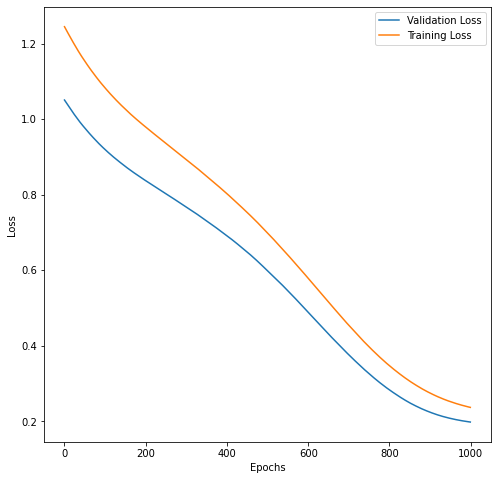

In [15]:
plot_loss(history)

# Task 7: Predictions

## 7.1: Plot Raw Predictions

Let's use the `compare_predictions` helper function to compare predictions from the model when it was untrained and when it was trained.

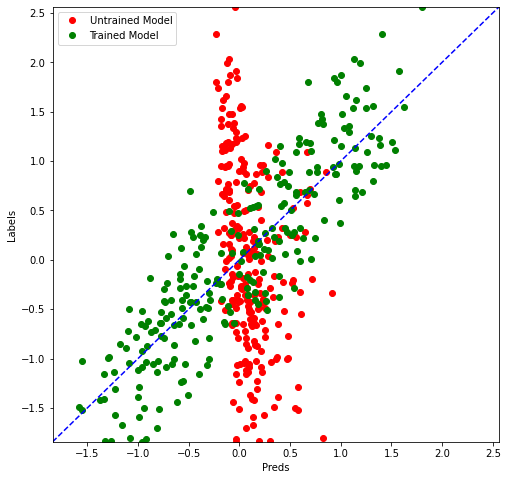

In [16]:
preds_on_trained = model.predict(X_test)

compare_predictions(preds_on_untrained, preds_on_trained, y_test)

## 7.2: Plot Price Predictions

The plot for price predictions and raw predictions will look the same with just one difference: The x and y axis scale is changed.

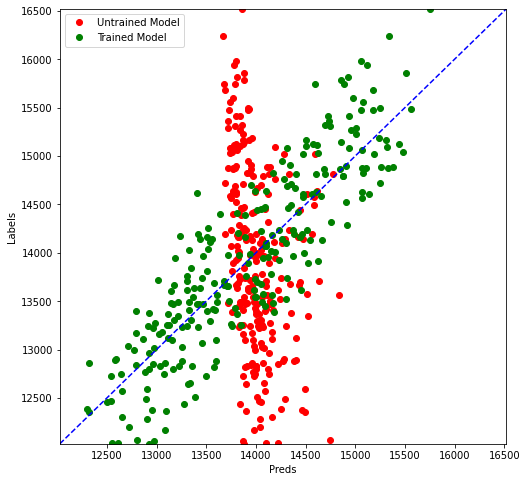

In [17]:
price_on_untrained = [convert_label_value(y) for y in preds_on_untrained]
price_on_trained = [convert_label_value(y) for y in preds_on_trained]
price_y_test = [convert_label_value(y) for y in y_test]

compare_predictions(price_on_untrained, price_on_trained, price_y_test)